In [2]:
import os
import h5py
import numpy as np

os.chdir("../scripts/data_preparation")  
label_shape = (100, 3)

# Clone fixed image to train
Start with images (formatted as just 1 fixed image from Weissbourd)

In [2]:
old_fixed_h5 = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\fixed_images.h5"
new_fixed_h5 = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\fixed_fixed_images.h5"
moving_h5 = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\moving_images.h5"
with h5py.File(old_fixed_h5, 'r') as f:
    assert len(f.keys()) == 1, "This is isn't the right program, bud"
    img = f[list(f.keys())[0]][:]
with h5py.File(new_fixed_h5, 'w') as f:
    with h5py.File(moving_h5, 'r') as g:
        for prob in g.keys():
            f.create_dataset(prob, data = img)

Then do the same for labels

In [3]:
old_fixed_h5 = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\fixed_labels.h5"
new_fixed_h5 = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\fixed_fixed_labels.h5"
moving_h5 = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\moving_labels.h5"
with h5py.File(old_fixed_h5, 'r') as f:
    assert len(f.keys()) == 1, "This is isn't the right program"
    labs = f[list(f.keys())[0]][:]
with h5py.File(new_fixed_h5, 'w') as f:
    with h5py.File(moving_h5, 'r') as g:
        for prob in g.keys():
            f.create_dataset(prob, data = labs)

Now add a third column so the labels have three dimensions

In [4]:
old_fixed_h5 = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\fixed_fixed_labels.h5"
new_fixed_h5 = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\fixed_fixed_fixed_labels.h5"
with h5py.File(old_fixed_h5, 'r') as f:
    assert f[list(f.keys())[0]][:].shape[1] == 2, "This is meant to expand the labels from 2D to 3D"
    with h5py.File(new_fixed_h5, 'w') as g:
        for prob in f.keys():
            labs = f[prob][:]
            labs = np.concatenate((labs, np.zeros((labs.shape[0], 1))), 1)
            labs = np.pad(labs, [(0,label_shape[0] - labs.shape[0]), (0,0)], "constant", constant_values=-1)
            g.create_dataset(prob, data = labs)

In [5]:
old_moving_h5 = os.path.join(base_folder, "moving_labels.h5")
new_moving_h5 = os.path.join(base_folder, "fixed_moving_labels.h5")
with h5py.File(old_moving_h5, 'r') as f:
    assert f[list(f.keys())[0]][:].shape[1] == 2, "This is meant to expand the labels from 2D to 3D"
    with h5py.File(new_moving_h5, 'w') as g:
        for prob in f.keys():
            labs = f[prob][:]
            labs = np.concatenate((labs, np.zeros((labs.shape[0], 1))), 1)
            labs = np.pad(labs, [(0,label_shape[0] - labs.shape[0]), (0,0)], "constant", constant_values=-1)
            g.create_dataset(prob, data = labs)

And add a third dim for the images

In [6]:
old_fixed_h5 = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\fixed_fixed_images.h5"
new_fixed_h5 = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\fixed_fixed_fixed_images.h5"
with h5py.File(old_fixed_h5, 'r') as f:
    assert len(f[list(f.keys())[0]][:].shape) == 2, "This is meant to expand the images from 2D to 3D"
    with h5py.File(new_fixed_h5, 'w') as g:
        for prob in f.keys():
            img = f[prob][:]
            img = np.expand_dims(img, 2)
            g.create_dataset(prob, data = img)

In [7]:
old_fixed_h5 = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\moving_images.h5"
new_fixed_h5 = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\fixed_moving_images.h5"
with h5py.File(old_fixed_h5, 'r') as f:
    assert len(f[list(f.keys())[0]][:].shape) == 2, "This is meant to expand the images from 2D to 3D"
    with h5py.File(new_fixed_h5, 'w') as g:
        for prob in f.keys():
            img = f[prob][:]
            img = np.expand_dims(img, 2)
            g.create_dataset(prob, data = img)

# Take unlabeled frames and add to a labeled h5

In [8]:
# import random, cv2, os

# old_img_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_h5s/full_lab_movds/fixed_images.h5"
# new_img_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/mixed_lab_h5/fixed_images.h5"

# old_label_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_h5s/full_lab_movds/fixed_labels.h5"
# new_label_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/mixed_lab_h5/fixed_labels.h5"

# old_img_moving_h5 = "/home/brian/data4/brian/PBnJ/jelly_h5s/full_lab_movds/moving_images.h5"
# new_img_moving_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/mixed_lab_h5/moving_images.h5"

# old_label_moving_h5 = "/home/brian/data4/brian/PBnJ/jelly_h5s/full_lab_movds/moving_labels.h5"
# new_label_moving_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/mixed_lab_h5/moving_labels.h5"

# frame_folder = "/home/brian/data4/brian/PBnJ/jelly_centroid_prep/zoomed_in_vid"

# num_frames_to_add = 500

# frame_names = [
#     os.path.splitext(p)[0] for p in os.listdir(frame_folder)
#     if os.path.splitext(p)[-1] in [".jpg"]
# ]

# probs = []

# for i in range(num_frames_to_add):
#     probs.append(tuple(random.sample(frame_names, 2)))

# # old_mean = 0
# old_max = 0
# # num = 0

# with h5py.File(new_img_fixed_h5, 'w-') as nif:
#     with h5py.File(new_label_fixed_h5, 'w-') as nlf:
#         with h5py.File(old_img_fixed_h5, 'r') as oif:
#             with h5py.File(old_label_fixed_h5, 'r') as olf:
#                 for prob in oif.keys():
#                     img = oif[prob][:]
#                     labs = olf[prob][:]

#                     # old_mean += np.mean(img)
#                     old_max = max(old_max, np.max(img))
#                     # num += 1

#                     nif.create_dataset(prob, data = img, dtype=float)
#                     nlf.create_dataset(prob, data = labs, dtype=np.float32)
        
#         # old_mean = old_mean / num
#         scale_factor = old_max / 255 # Photo max val
        
#         unlabeled_labs = np.ones_like(labs, dtype=np.float32) * -1
#         for fixed, moving in probs:
#             prob = f"{moving}to{fixed}"
#             img = cv2.imread(os.path.join(frame_folder, fixed + ".jpg"))[:,:,0:1]
#             nif.create_dataset(prob, data = img * scale_factor, dtype=float)
#             nlf.create_dataset(prob, data = unlabeled_labs, dtype=np.float32)





# with h5py.File(new_img_moving_h5, 'w-') as nim:
#     with h5py.File(new_label_moving_h5, 'w-') as nlm:
#         with h5py.File(old_img_moving_h5, 'r') as oim:
#             with h5py.File(old_label_moving_h5, 'r') as olm:
#                 for prob in oim.keys():
#                     img = oim[prob][:]
#                     labs = olm[prob][:]
#                     nim.create_dataset(prob, data = img, dtype=float)
#                     nlm.create_dataset(prob, data = labs, dtype=np.float32)

#         for fixed, moving in probs:
#             prob = f"{moving}to{fixed}"
#             img = cv2.imread(os.path.join(frame_folder, moving + ".jpg"))[:,:,0:1]
#             nim.create_dataset(prob, data = img * scale_factor, dtype=float)
#             nlm.create_dataset(prob, data = unlabeled_labs, dtype=np.float32)

## Crop

In [4]:
in_dir = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files"
out_dir = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\cropped"

crop_shape = np.array((1024, 1024, 1))

with h5py.File(os.path.join(in_dir, "fixed_moving_images.h5"), 'r') as imv,  h5py.File(os.path.join(in_dir, "fixed_moving_labels.h5"), 'r') as lmv, h5py.File(
    os.path.join(out_dir, "moving_images.h5"), 'w') as oimv,  h5py.File(os.path.join(out_dir, "moving_labels.h5"), 'w') as olmv:
    with h5py.File(os.path.join(in_dir, "fixed_fixed_fixed_images.h5"), 'r') as ifx,  h5py.File(os.path.join(in_dir, "fixed_fixed_fixed_labels.h5"), 'r') as lfx, h5py.File(
        os.path.join(out_dir, "fixed_images.h5"), 'w') as oifx,  h5py.File(os.path.join(out_dir, "fixed_labels.h5"), 'w') as olfx:
        for prob in imv.keys():
            img = imv[prob][:]
            imgF = ifx[prob][:]

            crop_offset = (img.shape - crop_shape) / 2
            assert np.all(crop_offset == crop_offset.astype(int))
            crop_offset = crop_offset.astype(int)

            ## Crop the images
            img = img[crop_offset[0]:crop_offset[0] + crop_shape[0], crop_offset[1]:crop_offset[1] + crop_shape[1], crop_offset[2]:crop_offset[2] + crop_shape[2]]
            assert np.all(img.shape == crop_shape)

            imgF = imgF[crop_offset[0]:crop_offset[0] + crop_shape[0], crop_offset[1]:crop_offset[1] + crop_shape[1], crop_offset[2]:crop_offset[2] + crop_shape[2]]
            assert np.all(imgF.shape == crop_shape), imgF.shape

            ## Adjust the labels
            labs = lmv[prob][:]
            neg_ones = labs < 0
            labs = labs - crop_offset 

            labsF = lfx[prob][:]
            neg_onesF = labsF < 0
            labsF = labsF - crop_offset
            assert np.all(neg_ones == neg_onesF), "Fixed and Moving labels have a different number of non negative 1 labels"
            
            # Remove centroids that are cropped out of the image
            crop = np.logical_or(labs < 0, labs >= crop_shape)
            crop = np.max(crop, axis=-1)
            cropF = np.logical_or(labsF < 0, labsF >= crop_shape)
            cropF = np.max(cropF, axis=-1)
            crop = np.logical_or(crop, cropF) # If either the fixed or moving are out of bounds then exclude both

            labs[crop] = -1
            labsF[crop] = -1

            labs[neg_ones] = -1 # Retain -1s
            labsF[neg_ones] = -1 # Retain -1s

            # Double check that all of the out of frame centroids are gone
            assert np.all(np.logical_or(labs >= 0, labs == -1)), "The crop results in moving centroids that are under bounds"
            assert np.all(labs < crop_shape[0]), "The crop results in moving centroids that are over bounds"
            assert np.all(np.logical_or(labsF >= 0, labsF == -1)), "The crop results in fixed centroids that are under bounds"
            assert np.all(labsF < crop_shape[0]), "The crop results in fixed centroids that are over bounds"

            assert np.all((labs == -1) == (labsF == -1)), "The labels that are excluded are not the same between moving and fixed"


            oimv.create_dataset(prob, data = img)
            olmv.create_dataset(prob, data = labs)
            oifx.create_dataset(prob, data = imgF)
            olfx.create_dataset(prob, data = labsF)


## Add Padding

In [5]:
# in_dir = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\cropped"
# out_dir = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\cropped\pad"

# padding = np.array([[0,0],[0,0],[1,0]])

# with h5py.File(os.path.join(in_dir, "moving_images.h5"), 'r') as imv,  h5py.File(os.path.join(in_dir, "moving_labels.h5"), 'r') as lmv:
#     with h5py.File(os.path.join(out_dir, "moving_images.h5"), 'w-') as oimv,  h5py.File(os.path.join(out_dir, "moving_labels.h5"), 'w-') as olmv:
#         for prob in imv.keys():
#             img = imv[prob][:]
#             # img = np.pad(img, padding, "constant", constant_values=0)
#             img = np.pad(img, padding, "constant", constant_values=np.min(img))

#             labs = lmv[prob][:]
#             neg_ones = labs < 0
#             labs = labs + padding[:, 0] 
#             labs[neg_ones] = -1 # Retain -1s

#             oimv.create_dataset(prob, data = img)
#             olmv.create_dataset(prob, data = labs)



# with h5py.File(os.path.join(in_dir, "fixed_images.h5"), 'r') as ifx,  h5py.File(os.path.join(in_dir, "fixed_labels.h5"), 'r') as lfx:
#     with h5py.File(os.path.join(out_dir, "fixed_images.h5"), 'w-') as oifx,  h5py.File(os.path.join(out_dir, "fixed_labels.h5"), 'w-') as olfx:
#         for prob in ifx.keys():
#             img = ifx[prob][:]
#             # img = np.pad(img, padding, "constant", constant_values=0)
#             img = np.pad(img, padding, "constant", constant_values=np.min(img))

#             labs = lfx[prob][:]
#             neg_ones = labs < 0
#             labs = labs + padding[:, 0] 
#             labs[neg_ones] = -1 # Retain -1s
            
#             oifx.create_dataset(prob, data = img)
#             olfx.create_dataset(prob, data = labs)
in_dir = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\cropped"
out_dir = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\cropped\pad"

os.makedirs(out_dir, exist_ok=True)

with h5py.File(os.path.join(in_dir, "moving_images.h5"), 'r') as imv, h5py.File(os.path.join(in_dir, "moving_labels.h5"), 'r') as lmv:
    with h5py.File(os.path.join(out_dir, "moving_images.h5"), 'w') as oimv, h5py.File(os.path.join(out_dir, "moving_labels.h5"), 'w') as olmv:
        for prob in imv.keys():
            img = imv[prob][:]
            labs = lmv[prob][:]
            
            valid_coords = labs[:, 2] >= 0
            labs[valid_coords, 2] = np.minimum(labs[valid_coords, 2], 1.0)
            
            oimv.create_dataset(prob, data=img)
            olmv.create_dataset(prob, data=labs)

with h5py.File(os.path.join(in_dir, "fixed_images.h5"), 'r') as ifx, h5py.File(os.path.join(in_dir, "fixed_labels.h5"), 'r') as lfx:
    with h5py.File(os.path.join(out_dir, "fixed_images.h5"), 'w') as oifx, h5py.File(os.path.join(out_dir, "fixed_labels.h5"), 'w') as olfx:
        for prob in ifx.keys():
            img = ifx[prob][:]
            labs = lfx[prob][:]
            
            valid_coords = labs[:, 2] >= 0
            labs[valid_coords, 2] = np.minimum(labs[valid_coords, 2], 1.0)
            
            oifx.create_dataset(prob, data=img)
            olfx.create_dataset(prob, data=labs)


In [ ]:
%env DEEPREG_LOG_LEVEL=0
import tensorflow as tf
# tf.debugging.enable_check_numerics()
# tf.config.experimental_run_functions_eagerly(True)
set_GPU(1)
fit_deepreg(
    config_path,
    log_dir,
    experiment_name,
    max_epochs,
    initial_epoch)


env: DEEPREG_LOG_LEVEL=0
2025-04-23 14:07:54 | WARNING  | Log directory C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish/demo_notebook\bb exists already.
Built inputs.
Built control points.
Concatenated images.
{'extract_levels': ListWrapper([0, 1, 2, 3]), 'name': 'local', 'num_channel_initial': 16}
Built backbone.
Built DDF.
Built warping.
Built outputs.


InvalidArgumentError: Graph execution error:

Detected at node DDFModel/model_2/centroid_warping/GatherNd_7 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\asyncio\base_events.py", line 608, in run_forever

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\asyncio\base_events.py", line 1936, in _run_once

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\asyncio\events.py", line 84, in _run

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\IPython\core\interactiveshell.py", line 3098, in run_cell

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\IPython\core\interactiveshell.py", line 3153, in _run_cell

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\IPython\core\interactiveshell.py", line 3362, in run_cell_async

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\IPython\core\interactiveshell.py", line 3607, in run_ast_nodes

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\IPython\core\interactiveshell.py", line 3667, in run_code

  File "C:\Users\5950x\AppData\Local\Temp\ipykernel_18176\373019459.py", line 6, in <module>

  File "c:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\scripts\train.py", line 86, in fit_deepreg

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\deepreg\callback.py", line 83, in build_checkpoint_callback

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\deepreg\model\network.py", line 293, in call

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\deepreg\model\layer.py", line 348, in call

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\deepreg\model\layer.py", line 403, in interpolate_warp

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\deepreg\model\layer.py", line 403, in interpolate_warp

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\deepreg\model\layer.py", line 417, in warp_coordinate_batch

indices[3,28] = [3, 969, 1023, 2] does not index into param shape [4,1024,1024,2,3], node name: DDFModel/model_2/centroid_warping/GatherNd_7
	 [[{{node DDFModel/model_2/centroid_warping/GatherNd_7}}]] [Op:__inference_train_function_51321]

In [ ]:
%env DEEPREG_LOG_LEVEL=0
import tensorflow as tf
# tf.debugging.enable_check_numerics()
# tf.config.experimental_run_functions_eagerly(True)
set_GPU(1)
fit_deepreg(
    config_path,
    log_dir,
    experiment_name,
    max_epochs,
    initial_epoch)


env: DEEPREG_LOG_LEVEL=0
2025-04-23 14:07:54 | WARNING  | Log directory C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish/demo_notebook\bb exists already.
Built inputs.
Built control points.
Concatenated images.
{'extract_levels': ListWrapper([0, 1, 2, 3]), 'name': 'local', 'num_channel_initial': 16}
Built backbone.
Built DDF.
Built warping.
Built outputs.


InvalidArgumentError: Graph execution error:

Detected at node DDFModel/model_2/centroid_warping/GatherNd_7 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\asyncio\base_events.py", line 608, in run_forever

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\asyncio\base_events.py", line 1936, in _run_once

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\asyncio\events.py", line 84, in _run

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\IPython\core\interactiveshell.py", line 3098, in run_cell

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\IPython\core\interactiveshell.py", line 3153, in _run_cell

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\IPython\core\interactiveshell.py", line 3362, in run_cell_async

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\IPython\core\interactiveshell.py", line 3607, in run_ast_nodes

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\IPython\core\interactiveshell.py", line 3667, in run_code

  File "C:\Users\5950x\AppData\Local\Temp\ipykernel_18176\373019459.py", line 6, in <module>

  File "c:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\scripts\train.py", line 86, in fit_deepreg

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\deepreg\callback.py", line 83, in build_checkpoint_callback

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\deepreg\model\network.py", line 293, in call

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\deepreg\model\layer.py", line 348, in call

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\deepreg\model\layer.py", line 403, in interpolate_warp

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\deepreg\model\layer.py", line 403, in interpolate_warp

  File "c:\Users\5950x\anaconda3\envs\cuda12_3_py3_11_9\Lib\site-packages\deepreg\model\layer.py", line 417, in warp_coordinate_batch

indices[3,28] = [3, 969, 1023, 2] does not index into param shape [4,1024,1024,2,3], node name: DDFModel/model_2/centroid_warping/GatherNd_7
	 [[{{node DDFModel/model_2/centroid_warping/GatherNd_7}}]] [Op:__inference_train_function_51321]

## Ceiling
#### log

In [ ]:
in_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/RFamide/full_lab/cropped/padded"
out_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/RFamide/full_lab/cropped/padded/log_scaled"



with h5py.File(os.path.join(in_dir, "moving_images.h5"), 'r') as imv,  h5py.File(os.path.join(in_dir, "moving_labels.h5"), 'r') as lmv:
    with h5py.File(os.path.join(out_dir, "moving_images.h5"), 'w') as oimv,  h5py.File(os.path.join(out_dir, "moving_labels.h5"), 'w') as olmv:
        for prob in imv.keys():
            img = imv[prob][:]
            labs = lmv[prob][:]
            
            img = np.log2(img + 1, dtype=np.float32)
            # img = np.log(img + 1, dtype=np.float32)

            oimv.create_dataset(prob, data = img)
            olmv.create_dataset(prob, data = labs)



with h5py.File(os.path.join(in_dir, "fixed_images.h5"), 'r') as ifx,  h5py.File(os.path.join(in_dir, "fixed_labels.h5"), 'r') as lfx:
    with h5py.File(os.path.join(out_dir, "fixed_images.h5"), 'w') as oifx,  h5py.File(os.path.join(out_dir, "fixed_labels.h5"), 'w') as olfx:
        for prob in ifx.keys():
            img = ifx[prob][:]
            labs = lfx[prob][:]
            
            img = np.log2(img + 1, dtype=np.float32)
            # img = np.log(img + 1, dtype=np.float32)
            
            oifx.create_dataset(prob, data = img)
            olfx.create_dataset(prob, data = labs)


/tmp/ipykernel_1638176/2015414748.py:12: RuntimeWarning: divide by zero encountered in log2
  img = np.log2(img + 1, dtype=np.float32)
/tmp/ipykernel_1638176/2015414748.py:26: RuntimeWarning: divide by zero encountered in log2
  img = np.log2(img + 1, dtype=np.float32)


#### sqrt

In [ ]:
in_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/RFamide/full_lab/cropped/sing_pad"
out_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/RFamide/full_lab/cropped/sing_pad/sqrt"



with h5py.File(os.path.join(in_dir, "moving_images.h5"), 'r') as imv,  h5py.File(os.path.join(in_dir, "moving_labels.h5"), 'r') as lmv:
    with h5py.File(os.path.join(out_dir, "moving_images.h5"), 'w') as oimv,  h5py.File(os.path.join(out_dir, "moving_labels.h5"), 'w') as olmv:
        for prob in imv.keys():
            img = imv[prob][:]
            labs = lmv[prob][:]
            
            img = np.sqrt(img, dtype=np.float32)

            oimv.create_dataset(prob, data = img)
            olmv.create_dataset(prob, data = labs)



with h5py.File(os.path.join(in_dir, "fixed_images.h5"), 'r') as ifx,  h5py.File(os.path.join(in_dir, "fixed_labels.h5"), 'r') as lfx:
    with h5py.File(os.path.join(out_dir, "fixed_images.h5"), 'w') as oifx,  h5py.File(os.path.join(out_dir, "fixed_labels.h5"), 'w') as olfx:
        for prob in ifx.keys():
            img = ifx[prob][:]
            labs = lfx[prob][:]
            
            img = np.sqrt(img, dtype=np.float32)
            
            oifx.create_dataset(prob, data = img)
            olfx.create_dataset(prob, data = labs)


In [ ]:
with h5py.File(new_fixed_h5, 'r') as f:
    probs = list(f.keys())
    print(probs)
    print(len(probs))

['0008to0000', '0017to0000', '0026to0000', '0035to0000', '0043to0000', '0052to0000', '0061to0000', '0070to0000', '0079to0000', '0087to0000', '0096to0000', '0105to0000', '0114to0000', '0123to0000', '0131to0000', '0140to0000', '0149to0000', '0158to0000', '0167to0000', '0175to0000', '0184to0000', '0193to0000', '0202to0000', '0211to0000', '0219to0000', '0228to0000', '0237to0000', '0246to0000', '0255to0000', '0263to0000', '0272to0000', '0281to0000', '0290to0000', '0298to0000', '0307to0000', '0316to0000', '0325to0000', '0334to0000', '0342to0000', '0351to0000', '0360to0000', '0369to0000', '0378to0000', '0386to0000', '0395to0000', '0404to0000', '0413to0000', '0422to0000', '0430to0000', '0439to0000', '0448to0000', '0457to0000', '0466to0000', '0474to0000', '0483to0000', '0492to0000', '0501to0000', '0510to0000', '0518to0000', '0527to0000', '0536to0000', '0545to0000', '0554to0000', '0562to0000', '0571to0000', '0580to0000', '0589to0000', '0597to0000', '0606to0000', '0615to0000', '0624to0000', '0633

# Split into training and val

In [8]:
import random, cv2, os
val_probs = random.sample(probs, 49)
print(val_probs)

ModuleNotFoundError: No module named 'cv2'

In [6]:
val_probs = [
            "3563to15011",
            "5004to15011",
            "6739to15011",
            "8110to15011",
            "985to15011"
        ]
# val_probs = ['4175to0000', '8140to0000', '5347to0000', '5683to0000', '5127to0000', '4480to0000', '5002to0000', '5417to0000', '8261to0000', '4215to0000', '5242to0000', '5753to0000', '5067to0000', '4455to0000', '4981to0000', '5082to0000', '5868to0000', '5843to0000', '5437to0000', '5948to0000', '8014to0000', '4871to0000', '5152to0000', '4691to0000', '8351to0000', '5748to0000', '5643to0000', '2841to0000', '4200to0000', '4035to0000', '8289to0000', '5728to0000', '5037to0000', '4606to0000', '4821to0000', '5563to0000', '5693to0000', '8002to0000', '5057to0000', '8273to0000', '5462to0000', '8203to0000', '4831to0000', '8297to0000', '4956to0000', '4450to0000', '5302to0000', '8022to0000', '4656to0000', '3999to0000', '5593to0000', '5653to0000', '4936to0000', '4561to0000', '5192to0000', '4060to0000', '5257to0000', '8367to0000', '5117to0000', '8257to0000', '4811to0000', '7683to0000', '5327to0000', '5402to0000', '8196to0000', '2105to0000', '4651to0000', '4566to0000', '4766to0000']
# val_probs = ['2984to0000', '3838to0000', '3315to0000', '0765to0000', '2572to0000', '3235to0000', '5215to0000', '0738to0000', '2683to0000', '5295to0000', '1662to0000', '4472to0000', '2773to0000', '5727to0000', '3305to0000', '1389to0000', '5396to0000', '4010to0000', '4883to0000', '4190to0000', '1688to0000', '1125to0000', '1468to0000', '2833to0000', '3657to0000', '1512to0000', '0712to0000', '1037to0000', '0413to0000', '2210to0000', '3567to0000', '0923to0000', '2522to0000', '3546to0000', '0263to0000', '5125to0000', '0395to0000', '0536to0000', '3205to0000', '5999to0000', '2552to0000', '1116to0000', '1407to0000', '0571to0000', '5506to0000', '5235to0000', '0114to0000', '3737to0000', '3587to0000']

base_dir = r"C:\Users\5950x\Desktop\JellyFishBAN\private_BrainAlign_jellyfish\demo_notebook\h5_files\cropped\pad"

os.mkdir(os.path.join(base_dir, "train"))
os.mkdir(os.path.join(base_dir, "val"))

old_img_fixed_h5 = f"{base_dir}/fixed_images.h5"
train_img_fixed_h5 = f"{base_dir}/train/fixed_images.h5"
val_img_fixed_h5 = f"{base_dir}/val/fixed_images.h5"

old_label_fixed_h5 = f"{base_dir}/fixed_labels.h5"
train_label_fixed_h5 = f"{base_dir}/train/fixed_labels.h5"
val_label_fixed_h5 = f"{base_dir}/val/fixed_labels.h5"

old_img_moving_h5 = f"{base_dir}/moving_images.h5"
train_img_moving_h5 = f"{base_dir}/train/moving_images.h5"
val_img_moving_h5 = f"{base_dir}/val/moving_images.h5"

old_label_moving_h5 = f"{base_dir}/moving_labels.h5"
train_label_moving_h5 = f"{base_dir}/train/moving_labels.h5"
val_label_moving_h5 = f"{base_dir}/val/moving_labels.h5"


with h5py.File(train_img_fixed_h5, 'w') as tif,  h5py.File(val_img_fixed_h5, 'w-') as vif:
    with h5py.File(train_label_fixed_h5, 'w') as tlf,  h5py.File(val_label_fixed_h5, 'w-') as vlf:
        with h5py.File(old_img_fixed_h5, 'r') as oif:
            with h5py.File(old_label_fixed_h5, 'r') as olf:
                for prob in oif.keys():
                    img = oif[prob][:]
                    labs = olf[prob][:]
                    if prob in val_probs:
                        vif.create_dataset(prob, data = img)
                        vlf.create_dataset(prob, data = labs)
                    else:
                        tif.create_dataset(prob, data = img)
                        tlf.create_dataset(prob, data = labs)
        

with h5py.File(train_img_moving_h5, 'w') as tim,  h5py.File(val_img_moving_h5, 'w-') as vim:
    with h5py.File(train_label_moving_h5, 'w') as tlm,  h5py.File(val_label_moving_h5, 'w-') as vlm:
        with h5py.File(old_img_moving_h5, 'r') as oim:
            with h5py.File(old_label_moving_h5, 'r') as olm:
                for prob in oim.keys():
                    img = oim[prob][:]
                    labs = olm[prob][:]
                    if prob in val_probs:
                        vim.create_dataset(prob, data = img)
                        vlm.create_dataset(prob, data = labs)
                    else:
                        tim.create_dataset(prob, data = img)
                        tlm.create_dataset(prob, data = labs)

### Create empty ROIs

In [ ]:
base_dir = "/home/brian/data4/brian/PBnJ/jelly_processed_data/mixed_lab_padded"

old_img_moving_h5 = f"{base_dir}/moving_images.h5"

train_roi_moving_h5 = f"{base_dir}/train/moving_rois.h5"
val_roi_moving_h5 = f"{base_dir}/val/moving_rois.h5"
train_roi_fixed_h5 = f"{base_dir}/train/fixed_rois.h5"
val_roi_fixed_h5 = f"{base_dir}/val/fixed_rois.h5"


with h5py.File(val_roi_fixed_h5, 'w-') as vrf,  h5py.File(val_roi_moving_h5, 'w-') as vrm:
# with h5py.File(train_roi_fixed_h5, 'w-') as trf,  h5py.File(train_roi_moving_h5, 'w-') as trm:
    with h5py.File(old_img_moving_h5, 'r') as oim:
        for prob in oim.keys():
            blank = np.zeros_like(oim[prob][:])
            vrf.create_dataset(prob, data = blank)
            vrm.create_dataset(prob, data = blank)
            # trf.create_dataset(prob, data = blank)
            # trm.create_dataset(prob, data = blank)

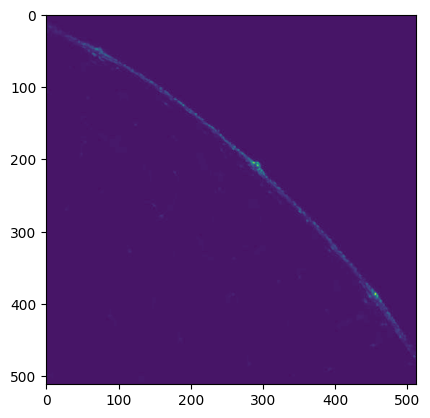

In [ ]:
plt.imshow(var[...,0])